$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [1]:
using SIAMFANLEquations
using SIAMFANLEquations.TestProblems
using PyPlot
using NotebookSIAMFANL

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260
┌ Info: Precompiling NotebookSIAMFANL [top-level]
└ @ Base loading.jl:1260


# Chapter 1: Introduction

## Section 1.1: What is the problem?

Nonlinear equations are solved as part of almost all simulations of
physical processes. Physical models that are expressed as
nonlinear partial differential equations, for example, become
large systems of nonlinear equations when discretized. Authors of
simulation codes must either use a nonlinear solver as a tool or
write one from scratch. The purpose of this book is to show
these authors what technology is available, sketch the implementation,
and warn of the problems. We do this via algorithmic outlines,
nonlinear solvers in Julia that can be used for
production work, a suite of example problems, an IJulia notebook,
and chapter-ending projects.

We use the standard notation

\begin{equation}
\mf(\vx) = 0
\end{equation}

for systems of $N$ equations in $N$ unknowns.
Here $\mf:R^N  \to R^N$. We will call $\mf$ the
__nonlinear residual__
 or simply the __residual__.
Rarely can the solution of a nonlinear equation be given by
a closed-form expression, so iterative methods must be used
to approximate the solution numerically.
The output of an iterative method
is a sequence of approximations to a solution.


### Section 1.1.1: Notation


In this book, following the convention in 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>
and
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>,
vectors are to be understood as column vectors.
We denote vectors by boldfaced lower case letters
and matrices by boldfaced upper case letters,
for example $\vx$  and $\ma$. We denote the $i$th component of $\vx$
by $x_i$ to distinguish between the $i$th member of a sequence of
vectors $\vx_i$. We denote the $ij$ entry of $\ma$ by $\ma_{ij}$.

The vector
$\vx^*$ will denote a solution, $x$ a potential solution,
and $\{ \vx_n \}_{n \ge 0}$ the sequence of iterates. We will refer to
$\vx_0$ as the
\index{Initial!guess}
\index{Initial!iterate}{\bf initial iterate (not guess!)}.
We will denote
the $i$th component of a vector $\vx$ by $x_i$
and the $i$th component of an index vector
$\vx_n$ by $x_{ni}$. We will rarely need
to refer to individual components of vectors.
We will let
$\partial \mf/\partial x_i$ denote the partial derivative of $\mf$
with respect to
$x_i$. As is standard
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
$\ve = \vx - \vx^*$ will denote the error. So, for example,
$\ve_n = \vx_n - \vx^*$ is the error in the $n$th iterate.
    
If the components of $\mf$ are differentiable at $\vx \in R^N$,
we define the __Jacobian matrix__
$\mf'(\vx)$ by
    
$$
\mf'(\vx)_{ij} = \frac{\partial f_i}{\partial x_j} (\vx).
$$
Throughout the book, $\| \cdot \|$ will denote the Euclidean norm
on $R^N$:
    
$$
\| \vx \| = \left( \sum_{i=1}^N x_i^2 \right)^{1/2}.
$$


We treat scalar equations with lowercase letters. So a scalar equation
is $f(x) = 0$ and the derivative is $f'(x)$.
Many of the essential ideas in this book can be illustrated with scalar
equations and we do that in this chapter. The exception is the need to
solver linear systems of equations and linear least squares problems, which
will be the focus of the remaining chapters in the book.
The Julia codes for the examples in this section are in the
[src/Chapter1](src/Chapter1)
directory for the notebook. The solvers and
test problems are part of the [SIAMFANLEquations](https://github.com/ctkelley/NotebookSIAMFANL) Julia package.
    


## Section 1.2: Newton's Method

Most of the methods in this book are variations of Newton's method.
The exception will be Anderson acceleration, which we cover in
Chapter~\ref{ch:anderson}.

The Newton sequence is

$$
\vx_{n+1} = \vx_n - \mf'(\vx_n)^{-1} \mf(\vx_n).
$$

The interpretation of \eqnok{newtonseq} is that
we model $\mf$ at the current iterate $\vx_n$ with a linear
function
$$
\mm_n(x) = \mf(\vx_n) + \mf'(\vx_n) (\vx - \vx_n)
$$
and let the root of $\mm_n$ be the next iteration.
$\mm_n$ is called the
__local linear model__.
If $\mf'(\vx_n)$ is
nonsingular, then the Newton sequence is the solution of $\mm_n(\vx_{n+1}) = 0$.

We illusrate  the local linear model and the
Newton iteration for the scalar equation
\[
\arctan(x) = 0
\]
with initial iterate $x_0 = 1$. We graph the local linear model
\[
m_j(x) = f(x_j) + f'(x_j) (x - x_j)
\]
at $x_j$ from the point $(x_j, y_j) = (x_j, f(x_j))$ to the next iteration
$(x_{j+1},0)$. The iteration converges rapidly and one can see the
linear model becoming more and more accurate. The third iterate is
visually indistinguishable from the solution.

Run the code window below to see the plot. The code __atan_test.jl__ runs the solver
__nsolsc.jl__ from the[SIAMFANLEquations](https://github.com/ctkelley/NotebookSIAMFANL) Julia package,
collects the data for the plot, and then runs some messy PyPlot commands. We will discuss the solver in detail
in [Section 1.10](#Section-1.10:-Scalar-Equation-Solver). For now we will focus on the results

The Julia program __fig1dot1.jl__
creates Figure 1.1 in this chapter. The semicolon after the function call suppresses some unnecessary output from PyPlot. Remove to see what happens.

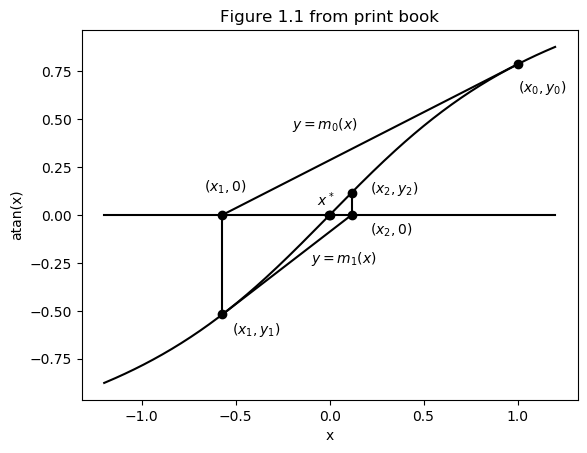

In [2]:
fig1dot1();

The computation of a Newton iteration requires

1. evaluation of $\mf(\vx_n)$ and a test for termination,
2. approximate solution of the equation
$\mf'(\vx_n) \vs = - \mf(\vx_n)$
for the Newton step $\vs$, and
3. construction of $\vx_{n+1} = \vx_n + \lambda \vs$, where the
step length $\lambda$ is selected to guarantee decrease in $\| \mf \|$.


The computation of the Newton step,
consumes most of the work, and the variations
in Newton's method that we discuss in this book differ most significantly
in how the Newton step is approximated. Computing the
step may require evaluation and factorization of the Jacobian matrix
or the solution of the linear equation by an iterative method.
Not all methods for computing
the Newton step require the complete Jacobian matrix, which, as we
will see in [Chapter 2](SIAMFANLCh2.ipynb)
can be very expensive.

In the example from Figure 1.1, the step $s$
in  was
satisfactory, and we can use $\lambda=1$ in step 3. The reader
should be warned that attention to the step length is generally very
important. One should not write one's own nonlinear solver without
step-length control (see [Section 1.6](#Section-1.10:-Global_Convergence_and_the_Armijo_Rule)).



### Section 1.2.1: Local Convergence Theory

The convergence theory for Newton's method 
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="ortega"><a href="siamfa.html#ortega">(OR70)</cite>,
that is most often seen in an elementary course in numerical methods
is __local__. This means
that one assumes that the __initial iterate__ $\vx_0$ is near a solution.
The local convergence
theory from
<cite data-cite="dens"><a href="siamfa.html#dens">(DS96)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="ortega"><a href="siamfa.html#ortega">(OR70)</cite>,
requires the __standard assumptions__.
    
---
__Assumption:__

1. The equation $\mf(\vx) = 0$ has a solution $\vx^*$.
2. $\mf': \Omega \to R^{N \times N}$ is Lipschitz continuous near $\vx^*$.}
3. $\mf'(\vx^*)$ is nonsingular.
---

Recall that Lipschitz continuity near $\vx^*$
means that there is $\gamma > 0$
(the __Lipschitz constant__) such that
    
$$
\| \mf'(\vx) - \mf'(\vy) \| \le \gamma \| \vx - \vy \|
$$
for all $\vx, \vy$ sufficiently near $\vx^*$.

We state the classic local convergence theorem.

___
__Theorem: (Local)__ Let the standard assumptions hold. If $\vx_0$ is sufficiently
near $\vx^*$, then the Newton sequence exists
(i.e., $\mf'(\vx_n)$ is nonsingular
for all $n \ge 0$) and converges to $\vx^*$ and there is $K > 0$ such that
    
$$
\| \ve_{n+1} \| \le K \| \ve_n \|^2
$$
for $n$ sufficiently large.
___


The convergence described by the theorem, in which
the error in the solution will be roughly squared with each iteration,
is called  __q-quadratic__. 
Squaring the error roughly means that the number of significant
figures in the result doubles with each iteration.  Of course,
one cannot examine the error without knowing the solution. However,
we can observe the quadratic reduction in the error computationally,
if $\mf'(\vx*)$ is well conditioned,
because the nonlinear residual
will also be roughly squared with each iteration.
Therefore, we should see the
exponent field of the norm of the nonlinear residual roughly double
with each iteration.
    
In Table 1.1 we report the Newton iteration
for the scalar ($N=1$) nonlinear equation
    
$$
f(x) = \tan(x) - x = 0, \, x_0 = 4.5.
$$
The solution is $x^* \approx 4.493$.

The decrease in the function
is as the theory predicts for the first three iterations, then progress
slows down for iteration 4 and stops completely after that. The
reason for this __stagnation__
is clear: one cannot evaluate the function
to higher precision than (roughly) machine unit roundoff, which in
the IEEE
<cite data-cite="ieee"><a href="siamfa.html#ieee">(IEE85)</cite>,
<cite data-cite="IEEEnew"><a href="siamfa.html#IEEEnew">(IEE19)</cite>,
<cite data-cite="overtonbook"><a href="siamfa.html#overtonbook">(Ove01)</cite>
floating point system is about $10^{-16}$.

We make Table 1.1 with __tab1dot1.jl__.


In [3]:
tab1dot1()

 n       |f(x)| 
 
 0   1.37332e-01  
 1   4.13194e-03  
 2   3.98176e-06  
 3   5.59552e-12  
 4   8.88178e-16  
 5   8.88178e-16  


Stagnation is not affected by the accuracy in the derivative. The
results reported in Table 1.1 used a
forward difference approximation to the derivative with a difference
increment of $10^{-6}$. With this choice of difference increment, the
convergence speed of the nonlinear iteration is as fast as
that for Newton's method, at least for this example, until stagnation
takes over.
The reader should be aware that difference approximations to derivatives,
while usually reliable, are often expensive and can be very inaccurate.
An inaccurate Jacobian can
cause many problems (see 
[Section 1.9](#Section-1.9:-What_Can_Go_Wrong) )

An analytic Jacobian
can require some human effort, but can be worth it in terms of
computer time and robustness when a difference Jacobian performs poorly.

One can quantify this stagnation by adding the errors in the function
evaluation and derivative evaluations to __Theorem: (Local)__
The messages of __Theorem: (Approximate)__ are as follows:

---
1. Small errors, for example, machine roundoff, in the function evaluation can lead to stagnation. This type of stagnation is usually benign and, if the Jacobian is well conditioned (see the estimate in [Section 1.5](#Section1.5:-Termination_of_the_Iteration) ),the results will be as accurate as the evaluation of $\mf$

2. Errors in the Jacobian and in the solution of the linear equation for the Newton step \eqnok{nstep} will affect the speed of the nonlinear iteration, but not the limit of the sequence.

---



__Theorem: (Approximate)__ 
Let the standard assumptions hold. Let a matrix-valued
function $\Delta(\vx)$ and a vector-valued function $\epsilon(\vx)$
be such that
$$
\| \Delta(\vx) \| < \delta_J \mbox{ and }
\| \epsilon(\vx) \| < \delta_F
$$
for all $\vx$ near $\vx^*$.
Then, if $\vx_0$ is sufficiently near $\vx^*$ and $\delta_J$ and
$\delta_F$ are sufficiently small, the sequence
$$
\vx_{n+1} = \vx_n -
( \mf'(\vx_n) + \Delta(\vx_n))^{-1} (\mf(\vx_n) + \epsilon(\vx_n))
$$
is defined (i.e., $\mf'(\vx_n) + \Delta(\vx_n)$ is nonsingular for all $n$)
and satisfies
$$
\| \ve_{n+1} \| \le {\bar K} ( \| \ve_n \|^2 + \| \Delta(\vx_n) \|
\| \ve_n \|
+ \| \epsilon(\vx_n)\| )
$$
for some ${\bar K} > 0$.

***

We will ignore the errors in the function in the rest of this book,
but one needs to be aware that stagnation of the nonlinear iteration
is all but certain in finite-precision arithmetic. However, the
asymptotic convergence results for exact arithmetic
describe the observations well for most problems.

While Table 1.1
gives a clear picture of quadratic convergence, it's
easier to appreciate a graph.
Figure 1.2 is a semilog plot of
__residual history}__ i.e.,
the norm of the nonlinear residual against the iteration number.
The concavity of the plot is the signature of superlinear convergence.
One uses the __semilogy__ command from the __PyPlot__ package
in Julia for this. See the
file __fig1dot2.jl__, which generated Figure 1.2
for an example.



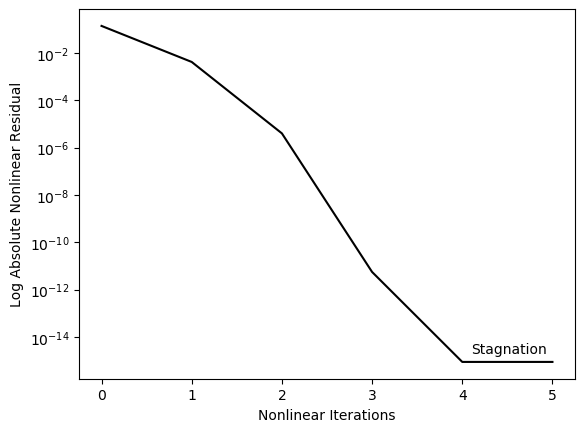

In [6]:
fig1dot2();

## Section 1.3: Approximating the Jacobian

As we will see in the subsequent chapters, it is usually most efficient
to approximate the Newton step in some way.
One way to do this is
to approximate $\mf'(\vx_n)$ in a way that not only avoids computation
of the derivative, but also saves linear algebra work and matrix storage.

The price for such an approximation is that the nonlinear iteration
converges more slowly; i.e., more nonlinear iterations
are needed to solve the problem.
However, the overall cost of the solve
is usually significantly less, because the computation of the
Newton step is less expensive.

One way to approximate the Jacobian is to
compute $\mf'(\vx_0)$ and use that as an approximation to
$\mf'(\vx_n)$
throughout the iteration.
This is the __chord method__
or __modified Newton method__.
The convergence
of the chord iteration is not as fast as Newton's method. Assuming
that the initial iteration is near enough to $x^*$, the convergence
is __q-linear__.
This means that there is $\rho \in (0,1)$ such that
$$
\| \ve_{n+1} \| \le \rho \| \ve_{n} \|
$$
for $n$ sufficiently large.
We can apply __Theorem: (Approximate)__ to the chord method with
$\epsilon=0$ and
$\| \Delta(\vx_n) \| = O(\| \ve_0 \|)$ and conclude that $\rho$ is
proportional to the initial error.
The constant $\rho$ is called the  __q-factor__.
The formal definition of q-linear convergence allows for faster
convergence.
Q-quadratic convergence is also q-linear, as you can see from the
definition.
In many cases of q-linear convergence, one observes that
$$
\| \ve_{n+1} \| \approx \rho \| \ve_{n} \|
\mbox{ or }
\| \mf(\vx_{n+1}) \| \approx \rho \| \mf(\vx_{n}) \|.
$$
In these cases,
q-linear convergence is usually easy to see on a semilog plot of the
residual norms against the iteration number. The curve appears to
be a line with slope $\approx \log(\rho)$.

The __secant method__ 
for scalar equations approximates the
derivative using a finite difference, but, rather than a forward
difference, uses the most recent two iterations to form
the difference quotient. So
$$
x_{n+1} = x_n - \frac{f(x_n)(x_n - x_{n-1})}{f(x_n)- f(x_{n-1})},
$$
where $x_n$ is the current iteration and $x_{n-1}$ is the
iteration before that. The secant method must be initialized
with two points. One way to do that is to let
$x_{-1} = 0.99 x_0$. This is what we do in our Julia code __nsolsc.jl__, which
includes the Newton, chord, and secant methods as options.

The formula for the secant method does not extend to
systems of equations ($N > 1$) because the denominator in the fraction
would be a difference of vectors. We discuss one of the
many generalizations of the secant method for systems of equations
in 
[Chapter 5](SIAMFANLCh5.ipynb).

The secant method's approximation to $f'(x_n)$ converges to $f'(x^*)$
as the iteration progresses. __Theorem: (Approximate)__, with
$\epsilon=0$ and $\| \Delta(x_n) \| = O(\| e_{n-1} \|)$, implies that
the iteration
converges __q-superlinearly__. This means that either $x_n = x^*$
for some finite $n$ or
$$
\lim_{n \to \infty} \dfrac{\| e_{n+1} \|}{\| e_{n} \|} = 0.
$$
Q-superlinear convergence is hard to distinguish from q-quadratic
convergence by visual inspection of the semilog plot of the residual history.
The residual curve for q-superlinear convergence is concave down
but drops less rapidly than the one for Newton's method.



## Section 1.4: Inexact Newton Methods

## Section 1.5: Termination of the Iteration

## Section 1.6: Global Convergence and the Armijo Rule

## Section 1.7: Pseudo-Transient Continuation

## Section 1.8: Things to Consider

## Section 1.9: What Can Go Wrong?


## Section 1.10: Scalar Equation Solver